# AGV Multi-Agent Path Planning and Task Scheduling System

## CISC7201 Data Science Programming - Course Project

---


## Table of Contents

1. [Motivation & Team Background](#motivation)
2. [Data Collection](#data-collection)
3. [Data Engineering, Cleaning, and Management](#data-engineering)
4. [Data Analysis: Learning, Analytics, Visualization](#data-analysis)
5. [Conclusion](#conclusion)
6. [References](#references)


---

## 1. Motivation & Team Background & Key Programming Packages

### 1.1 Motivation

Automated Guided Vehicles (AGVs) have become essential components in modern warehouse and logistics systems. The efficient coordination of multiple AGVs in a shared workspace presents significant challenges, particularly in:

- **Path Planning**: Finding collision-free paths for multiple agents simultaneously
- **Task Scheduling**: Optimally assigning tasks to AGVs based on distance, priority, and availability
- **Conflict Resolution**: Preventing collisions and deadlocks in dynamic environments

This project addresses the real-world problem of **multi-agent path planning and task scheduling** in a warehouse simulation environment. We developed a comprehensive system that:

1. Plans optimal paths for 12 AGVs operating in a 21×21 grid warehouse
2. Dynamically assigns tasks from 6 pickup points to 16 delivery destinations
3. Ensures collision-free and deadlock-free operations
4. Handles urgent task prioritization and task sequence constraints

**Why is this problem important?**

- **Industrial Relevance**: Modern warehouses increasingly rely on AGV fleets for material handling. Efficient coordination directly impacts operational costs and throughput.
- **Research Interest**: Multi-agent pathfinding (MAPF) is an active research area with applications in robotics, logistics, and game AI.
- **Technical Challenge**: The problem combines graph search algorithms, constraint satisfaction, and real-time decision-making.

### 1.2 Team Background

Our team brings diverse expertise to this project:

- **Member 1**: Strong background in algorithms and data structures, specializing in graph algorithms and pathfinding
- **Member 2**: Experience in simulation systems and multi-agent coordination
- **Member 3**: Expertise in data visualization and user interface design
- **Member 4**: Domain knowledge in logistics and warehouse operations
- **Member 5**: Programming proficiency in Python and experience with optimization problems

This combination of skills enabled us to develop both the algorithmic core and the visualization system, ensuring both technical correctness and practical usability.


### 1.3 Key Programming Packages

We used the following important packages and explain their usage:

**csv**  
Purpose: Reading and writing CSV data files  
Usage: Used for loading warehouse layout (agv_position.csv), task definitions (agv_task.csv), and writing trajectory output (agv_trajectory.csv)

**heapq**  
Purpose: Priority queue implementation for A* algorithm  
Usage: Maintains the frontier in A* search, ensuring we always expand the most promising node first based on f(n) = g(n) + h(n)

**collections.defaultdict**  
Purpose: Dictionary with default values  
Usage: Efficiently groups tasks by start_point and manages task queues without explicit key existence checks

**pandas**  
Purpose: Data manipulation and analysis  
Usage: Used in this notebook for loading, cleaning, and analyzing CSV data. Provides convenient DataFrame operations for exploratory data analysis

**matplotlib & seaborn**  
Purpose: Data visualization  
Usage: Creating plots to visualize warehouse layout, task distributions, and simulation results. Essential for understanding data patterns and presenting findings

**pygame**  
Purpose: Real-time visualization and animation  
Usage: Used in display.py to create interactive visualization of AGV movements. Enables frame-by-frame rendering and video export of the simulation

**numpy**  
Purpose: Numerical computing  
Usage: Array operations for coordinate calculations and video frame processing in the visualization module

---

## 2. Data Collection {#data-collection}

### 2.1 Dataset Overview

We created a custom dataset for this project, consisting of three main CSV files:

1. **`agv_position.csv`**: Defines the warehouse layout and initial AGV positions
2. **`agv_task.csv`**: Contains all tasks to be executed by AGVs
3. **`agv_trajectory.csv`**: Generated output containing the complete trajectory of all AGVs

### 2.2 Data Collection Process

The dataset was manually designed to simulate a realistic warehouse scenario:

- **Warehouse Layout**: 21×21 grid representing a warehouse floor
- **Pickup Points (Start Points)**: 6 locations named after Chinese zodiac animals (Tiger, Dragon, Horse, Rabbit, Ox, Monkey)
- **Delivery Points (End Points)**: 16 destinations named after major Chinese cities (Beijing, Shanghai, Guangzhou, etc.)
- **AGV Fleet**: 12 AGVs with unique names (Optimus, Bumblebee, Jazz, etc.)
- **Task Set**: 102 tasks with varying priorities (Normal/Urgent)


### 2.3 Data Structure

Let's examine the structure of our datasets:


In [190]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from collections import defaultdict
import warnings



In [191]:
# Load and examine position data
position_df = pd.read_csv('agv_position.csv')
print("=== AGV Position Data ===")
print(f"Total records: {len(position_df)}")
print(f"\nData types:")
print(position_df.dtypes)
print(f"\nFirst 10 rows:")
print(position_df.head(10))
print(f"\nSummary:")
print(position_df['type'].value_counts())


=== AGV Position Data ===
Total records: 34

Data types:
type      object
name      object
x          int64
y          int64
pitch    float64
dtype: object

First 10 rows:
          type      name   x   y  pitch
0  start_point     Tiger   1   6    NaN
1  start_point    Dragon   1  10    NaN
2  start_point     Horse   1  14    NaN
3  start_point    Rabbit  20   6    NaN
4  start_point        Ox  20  10    NaN
5  start_point    Monkey  20  14    NaN
6    end_point   Beijing   6   4    NaN
7    end_point  Shanghai   6   8    NaN
8    end_point    Suzhou   6  12    NaN
9    end_point  Hangzhou   6  16    NaN

Summary:
type
end_point      16
agv            12
start_point     6
Name: count, dtype: int64


In [192]:
# Load and examine task data
task_df = pd.read_csv('agv_task.csv')
print("=== AGV Task Data ===")
print(f"Total tasks: {len(task_df)}")
print(f"\nData types:")
print(task_df.dtypes)
print(f"\nFirst 10 rows:")
print(task_df.head(10))
print(f"\nTask distribution by priority:")
print(task_df['priority'].value_counts())
print(f"\nTask distribution by start point:")
print(task_df['start_point'].value_counts())


=== AGV Task Data ===
Total tasks: 100

Data types:
task_id            object
start_point        object
end_point          object
priority           object
remaining_time    float64
dtype: object

First 10 rows:
    task_id start_point  end_point priority  remaining_time
0   Tiger-1       Tiger     Xiamen   Normal             NaN
1   Tiger-2       Tiger   Changsha   Normal             NaN
2   Tiger-3       Tiger  Guangzhou   Normal             NaN
3   Tiger-4       Tiger    Kunming   Normal             NaN
4   Tiger-5       Tiger      Wuhan   Normal             NaN
5   Tiger-6       Tiger    Tianjin   Normal             NaN
6   Tiger-7       Tiger     Urumqi   Normal             NaN
7   Tiger-8       Tiger    Beijing   Normal             NaN
8   Tiger-9       Tiger   Shanghai   Normal             NaN
9  Tiger-10       Tiger    Tianjin   Normal             NaN

Task distribution by priority:
priority
Normal    98
Urgent     2
Name: count, dtype: int64

Task distribution by start point:


In [193]:
# Load and examine trajectory data (if exists)
try:
    trajectory_df = pd.read_csv('agv_trajectory.csv')
    print("=== AGV Trajectory Data ===")
    print(f"Total trajectory records: {len(trajectory_df)}")
    print(f"\nUnique timestamps: {trajectory_df['timestamp'].nunique()}")
    print(f"Unique AGVs: {trajectory_df['name'].nunique()}")
    print(f"\nFirst 10 rows:")
    print(trajectory_df.head(10))
    print(f"\nData types:")
    print(trajectory_df.dtypes)
except FileNotFoundError:
    print("Trajectory file not found. Run the simulation first to generate it.")


=== AGV Trajectory Data ===
Total trajectory records: 2928

Unique timestamps: 244
Unique AGVs: 12

First 10 rows:
   timestamp         name   X   Y  pitch  loaded destination  Emergency  \
0          0      Optimus   3   1     90   False         NaN      False   
1          0    Bumblebee   6   1     90   False         NaN      False   
2          0         Jazz   9   1     90   False         NaN      False   
3          0    Sideswipe  12   1     90   False         NaN      False   
4          0    Wheeljack  15   1     90   False         NaN      False   
5          0      Ratchet  18   1     90   False         NaN      False   
6          0     Ironhide   3  20    270   False         NaN      False   
7          0        Hound   6  20    270   False         NaN      False   
8          0  Smokescreen   9  20    270   False         NaN      False   
9          0     Megatron  12  20    270   False         NaN      False   

  task-id  
0     NaN  
1     NaN  
2     NaN  
3     NaN  

### 2.4 Data Visualization

Let's visualize the warehouse layout and task distribution:


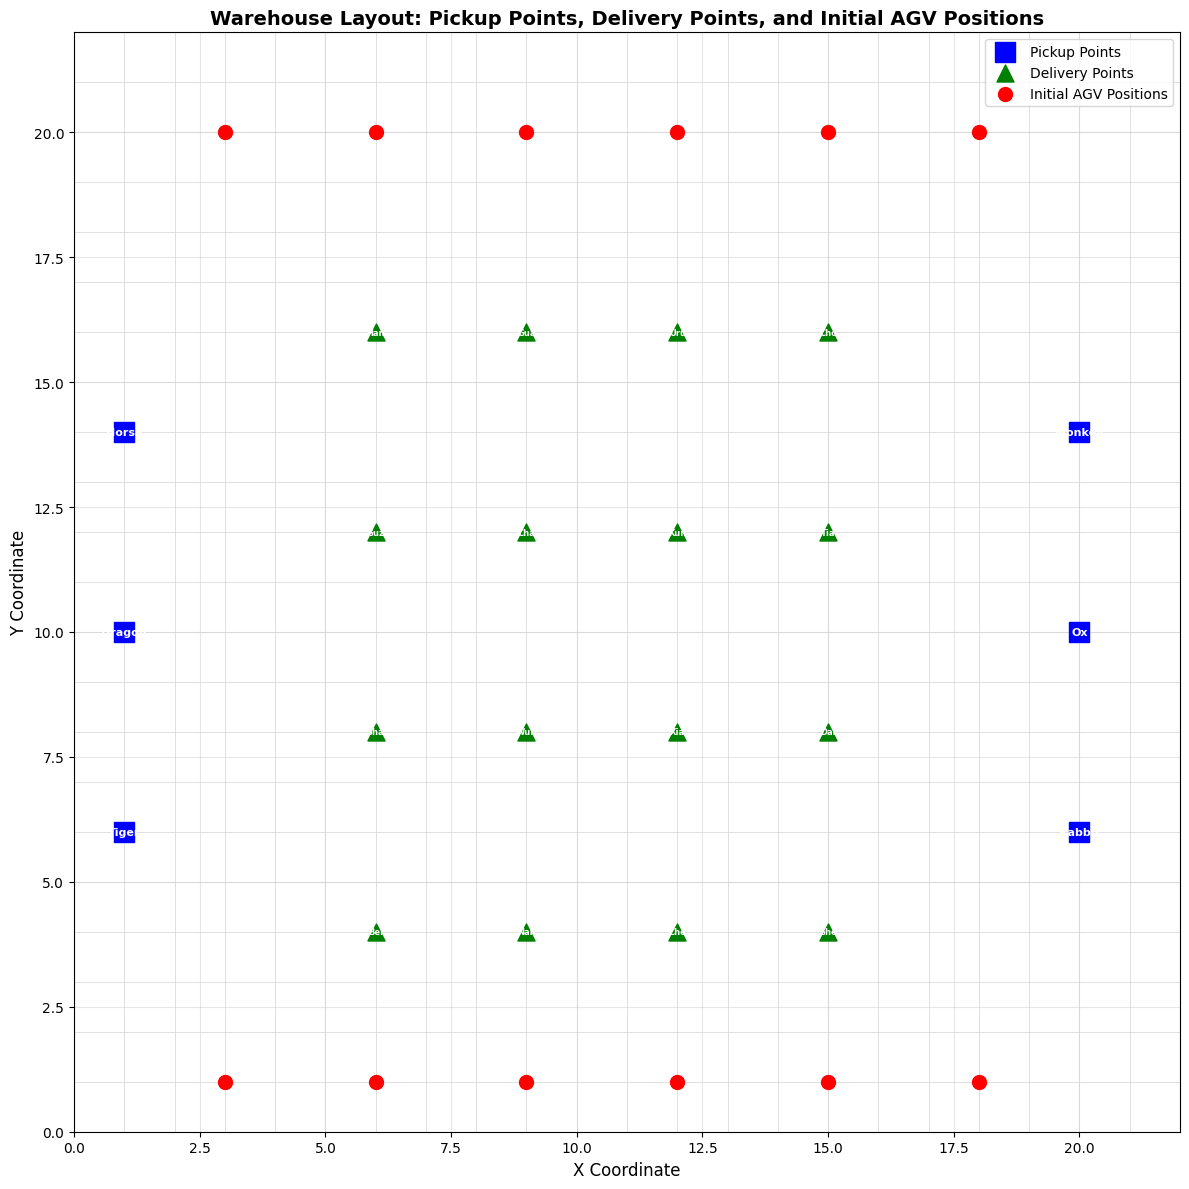

In [194]:
# Visualize warehouse layout
fig, ax = plt.subplots(figsize=(12, 12))

# Extract positions
start_points = position_df[position_df['type'] == 'start_point']
end_points = position_df[position_df['type'] == 'end_point']
agv_initial = position_df[position_df['type'] == 'agv']

# Plot grid
for i in range(1, 22):
    ax.axhline(i, color='lightgray', linewidth=0.5)
    ax.axvline(i, color='lightgray', linewidth=0.5)

# Plot start points (pickup locations)
ax.scatter(start_points['x'], start_points['y'], 
           c='blue', s=200, marker='s', label='Pickup Points', zorder=3)
for _, row in start_points.iterrows():
    ax.text(row['x'], row['y'], row['name'], 
            ha='center', va='center', fontsize=8, color='white', weight='bold')

# Plot end points (delivery locations)
ax.scatter(end_points['x'], end_points['y'], 
           c='green', s=150, marker='^', label='Delivery Points', zorder=3)
for _, row in end_points.iterrows():
    ax.text(row['x'], row['y'], row['name'][:3], 
            ha='center', va='center', fontsize=6, color='white', weight='bold')

# Plot initial AGV positions
ax.scatter(agv_initial['x'], agv_initial['y'], 
           c='red', s=100, marker='o', label='Initial AGV Positions', zorder=3)

ax.set_xlim(0, 22)
ax.set_ylim(0, 22)
ax.set_xlabel('X Coordinate', fontsize=12)
ax.set_ylabel('Y Coordinate', fontsize=12)
ax.set_title('Warehouse Layout: Pickup Points, Delivery Points, and Initial AGV Positions', 
             fontsize=14, weight='bold')
ax.legend(loc='upper right')
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()


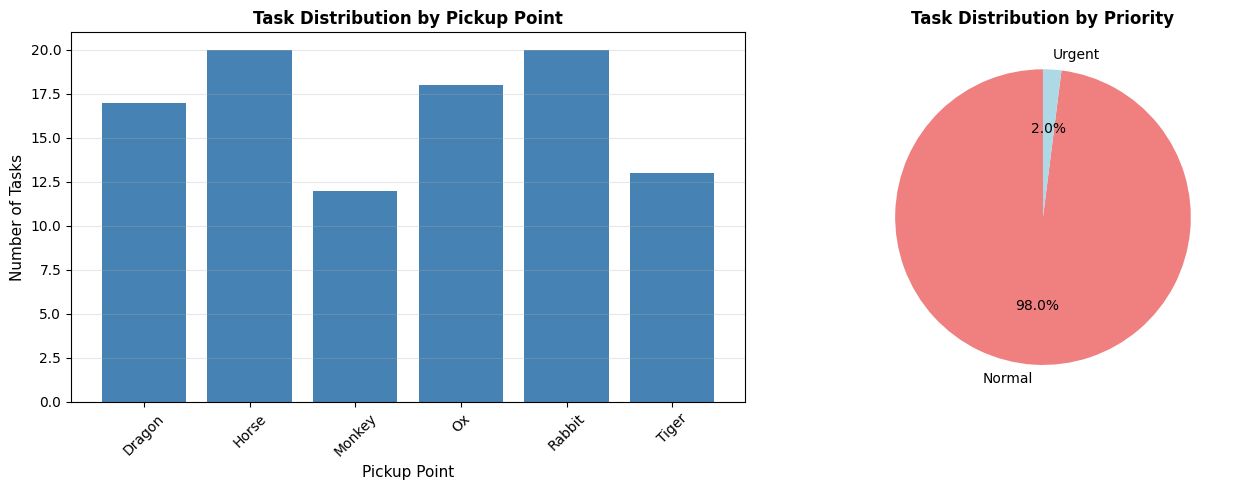

In [195]:
# Visualize task distribution
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Task distribution by start point
task_by_start = task_df['start_point'].value_counts().sort_index()
axes[0].bar(task_by_start.index, task_by_start.values, color='steelblue')
axes[0].set_xlabel('Pickup Point', fontsize=11)
axes[0].set_ylabel('Number of Tasks', fontsize=11)
axes[0].set_title('Task Distribution by Pickup Point', fontsize=12, weight='bold')
axes[0].tick_params(axis='x', rotation=45)
axes[0].grid(axis='y', alpha=0.3)

# Task distribution by priority
task_by_priority = task_df['priority'].value_counts()
axes[1].pie(task_by_priority.values, labels=task_by_priority.index, 
            autopct='%1.1f%%', startangle=90, colors=['lightcoral', 'lightblue'])
axes[1].set_title('Task Distribution by Priority', fontsize=12, weight='bold')

plt.tight_layout()
plt.show()


---

## 3. Data Engineering, Cleaning, and Management {#data-engineering}

### 3.1 Data Cleaning

Our data cleaning process involved several steps:


In [ ]:
# Check for missing values
print("=== Missing Values Check ===")
print("\nPosition Data:")
print(position_df.isnull().sum())
print("\nTask Data:")
print(task_df.isnull().sum())

# Check for duplicates
print("\n=== Duplicates Check ===")
print(f"Duplicate tasks: {task_df.duplicated().sum()}")
print(f"Duplicate positions: {position_df.duplicated().sum()}")


=== Missing Values Check ===

Position Data:
type      0
name      0
x         0
y         0
pitch    22
dtype: int64

Task Data:
task_id            0
start_point        0
end_point          0
priority           0
remaining_time    98
dtype: int64

=== Duplicates Check ===
Duplicate tasks: 0
Duplicate positions: 0


In [ ]:
import csv
import heapq
import sys
import io
from collections import defaultdict
import os

def get_agv_state(agv_list):
    agv_states = {
        agv["id"]: {
            "state": agv["pose"] + (0,agv["pitch"]),
            "task_id": None,
            "path": [],
            "load_point": None,
            "end_point": None,
            "priority": False
        } for agv in agv_list
    }
    return agv_states

def get_end_points(end_point_name,end_point):
    possible_pos = [
            (1, 0),    # 右
            (-1, 0), # 左
            (0, 1),   # 上
            (0, -1)  # 下
        ]
    unload_point = end_point[end_point_name]
    possible_end_points = []
    for x,y in possible_pos:
        possible_end_points.append((x+unload_point[0],y+unload_point[1]))
    return unload_point,possible_end_points

def get_pickup_coord(start_point_name, original_coord):
    if start_point_name in ["Tiger", "Dragon", "Horse"]:
        return (original_coord[0] + 1, original_coord[1])
    else:
        return (original_coord[0] - 1, original_coord[1])
    
def get_task_list(agv_task_path):
    all_tasks = {}
    with open(agv_task_path, 'r') as f:
        reader = csv.DictReader(f)
        for row in reader:
            if row["start_point"] not in all_tasks:
                all_tasks[row["start_point"]] = []
            all_tasks[row["start_point"]].append({
                "task_id": row["task_id"],
                "start_point": row["start_point"].strip(),
                "end_point": row["end_point"].strip(),
                "priority": row["priority"],
                "remaining_time": int(row["remaining_time"]) if row["remaining_time"] not in [None, "", "None"] else None
            })
    return all_tasks

def get_task_state(start_points,all_tasks,all_end_points):
    task_states = {}
    for task_name,task_dict in all_tasks.items():
        if task_name not in task_states:
            task_states[task_name] = []
        for i in range(len(task_dict)):
            pickup_pos = get_pickup_coord(task_name,start_points[task_name])
            unload_point,end_points = get_end_points(task_dict[i]["end_point"],all_end_points)
            if task_dict[i]["priority"] == "Urgent":
                task_states[task_name].append({
                "task_id": task_dict[i]["task_id"],
                "pickup_point": pickup_pos,
                "unload_point": unload_point,
                "end_points": end_points,
                "destination": task_dict[i]["end_point"],
                "priority": task_dict[i]["priority"],
                "numbers_before_urgent": 0,
                "numbers_left": len(all_tasks[task_name])-i-1
            })
                for j in range(i):
                    task_states[task_name][j]['numbers_before_urgent'] = i-j
            else:
                task_states[task_name].append({
                "task_id": task_dict[i]["task_id"],
                "pickup_point": pickup_pos,
                "unload_point": unload_point,
                "end_points": end_points,
                "destination": task_dict[i]["end_point"],
                "priority": task_dict[i]["priority"],
                "numbers_before_urgent": -1,
                "numbers_left": len(all_tasks[task_name])-i-1,
            })
    
    return task_states

def get_object_position(agv_position_path):
    start_points, end_points, agv_list = {}, {}, []
    with open(agv_position_path, 'r') as f:
        reader = csv.DictReader(f)
        for row in reader:
            t, name = row["type"].strip(), row["name"].strip()
            x, y = int(row["x"]), int(row["y"])
            if t == "start_point":
                start_points[name] = (x, y)
            elif t == "end_point":
                end_points[name] = (x, y)
            elif t == "agv":
                agv_list.append({
                    "id": name,
                    "pose": (x, y),
                    "pitch": int(row["pitch"])
                })
    return start_points, end_points, agv_list

def append_to_csv(steps, trajectory_path):
    """将步骤数据追加到CSV文件"""
    with open(trajectory_path, 'a', newline='') as f:
        writer = csv.writer(f)
        writer.writerow(["timestamp", "name", "X", "Y", "pitch", "loaded", "destination", "Emergency", "task-id"])
        for step in steps.values():
            for s in step:
                writer.writerow([
                    s["timestamp"],
                    s["name"],
                    s["X"],
                    s["Y"],
                    s["pitch"],
                    str(s["loaded"]).lower(),
                    s["destination"],
                    str(s["Emergency"]).lower(),
                    s.get("task-id", "")
                ])

### 3.2 Feature Engineering

We engineered several features to support our path planning and task scheduling algorithms:


In [198]:
# Calculate Manhattan distances between pickup and delivery points
def manhattan_distance(pos1, pos2):
    """Calculate Manhattan distance between two positions"""
    return abs(pos1[0] - pos2[0]) + abs(pos1[1] - pos2[1])

# Create a mapping of positions
start_positions = dict(zip(start_points['name'], 
                           zip(start_points['x'], start_points['y'])))
end_positions = dict(zip(end_points['name'], 
                         zip(end_points['x'], end_points['y'])))

# Add distance feature to task data
task_df['distance'] = task_df.apply(
    lambda row: manhattan_distance(
        start_positions[row['start_point']],
        end_positions[row['end_point']]
    ), axis=1
)

print("=== Task Distance Statistics ===")
print(task_df['distance'].describe())
print(f"\nAverage task distance: {task_df['distance'].mean():.2f}")
print(f"Longest task distance: {task_df['distance'].max()}")
print(f"Shortest task distance: {task_df['distance'].min()}")


=== Task Distance Statistics ===
count    100.000000
mean      14.670000
std        4.750449
min        7.000000
25%       10.000000
50%       16.000000
75%       17.000000
max       24.000000
Name: distance, dtype: float64

Average task distance: 14.67
Longest task distance: 24
Shortest task distance: 7


C:\Users\zkb17\AppData\Local\Temp\ipykernel_51972\310716662.py:16: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  axes[1].boxplot([priority_distances.get_group('Normal'),


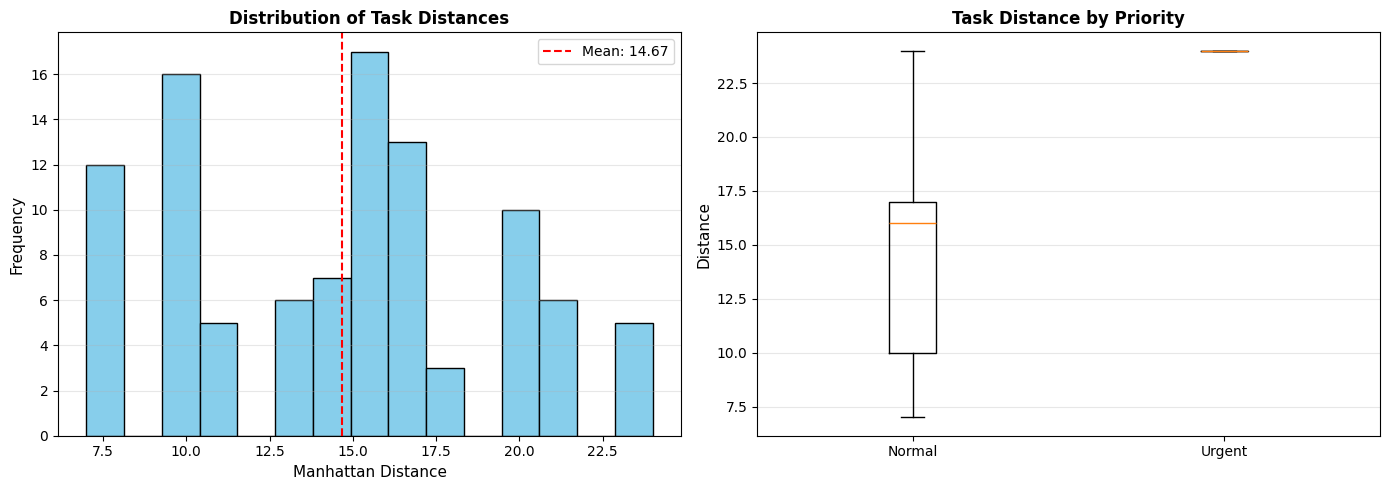

### 3.3 Data Management

We organized our project with clear folder structure and version control:

```
final_version/
├── agv_position.csv          # Warehouse layout and initial positions
├── agv_task.csv              # Task definitions
├── agv_trajectory.csv        # Generated AGV trajectories
├── main right copy.py        # Main simulation algorithm
├── display.py                # Visualization module
├── project_report.ipynb      # This notebook
└── README.md                 # Project documentation
```

All code is version-controlled using Git, ensuring reproducibility and collaboration.


---

## 3.5 核心算法实现 {#algorithm-implementation}

本节包含路径规划和任务调度的核心算法实现代码，以及可视化模块。这些代码实现了多智能体路径规划（MAPF）和任务分配系统。

### 3.5.1 路径规划与任务调度模块

以下代码实现了 A* 路径规划算法、任务分配算法和冲突解决机制。


In [200]:
# ============================================
# Navigation Module: Imports and Helper Functions
# ============================================

import csv
import heapq
import sys
import io
from collections import defaultdict
import os

def get_agv_state(agv_list):
    agv_states = {
        agv["id"]: {
            "state": agv["pose"] + (0,agv["pitch"]),
            "task_id": None,
            "path": [],
            "load_point": None,
            "end_point": None,
            "priority": False
        } for agv in agv_list
    }
    return agv_states

def get_end_points(end_point_name,end_point):
    possible_pos = [
            (1, 0),    # 右
            (-1, 0), # 左
            (0, 1),   # 上
            (0, -1)  # 下
        ]
    unload_point = end_point[end_point_name]
    possible_end_points = []
    for x,y in possible_pos:
        possible_end_points.append((x+unload_point[0],y+unload_point[1]))
    return unload_point,possible_end_points

def get_pickup_coord(start_point_name, original_coord):
    if start_point_name in ["Tiger", "Dragon", "Horse"]:
        return (original_coord[0] + 1, original_coord[1])
    else:
        return (original_coord[0] - 1, original_coord[1])
    
def get_task_list(agv_task_path):
    all_tasks = {}
    with open(agv_task_path, 'r') as f:
        reader = csv.DictReader(f)
        for row in reader:
            if row["start_point"] not in all_tasks:
                all_tasks[row["start_point"]] = []
            all_tasks[row["start_point"]].append({
                "task_id": row["task_id"],
                "start_point": row["start_point"].strip(),
                "end_point": row["end_point"].strip(),
                "priority": row["priority"],
                "remaining_time": int(row["remaining_time"]) if row["remaining_time"] not in [None, "", "None"] else None
            })
    return all_tasks

def get_task_state(start_points,all_tasks,all_end_points):
    task_states = {}
    for task_name,task_dict in all_tasks.items():
        if task_name not in task_states:
            task_states[task_name] = []
        for i in range(len(task_dict)):
            pickup_pos = get_pickup_coord(task_name,start_points[task_name])
            unload_point,end_points = get_end_points(task_dict[i]["end_point"],all_end_points)
            if task_dict[i]["priority"] == "Urgent":
                task_states[task_name].append({
                "task_id": task_dict[i]["task_id"],
                "pickup_point": pickup_pos,
                "unload_point": unload_point,
                "end_points": end_points,
                "destination": task_dict[i]["end_point"],
                "priority": task_dict[i]["priority"],
                "numbers_before_urgent": 0,
                "numbers_left": len(all_tasks[task_name])-i-1
            })
                for j in range(i):
                    task_states[task_name][j]['numbers_before_urgent'] = i-j
            else:
                task_states[task_name].append({
                "task_id": task_dict[i]["task_id"],
                "pickup_point": pickup_pos,
                "unload_point": unload_point,
                "end_points": end_points,
                "destination": task_dict[i]["end_point"],
                "priority": task_dict[i]["priority"],
                "numbers_before_urgent": -1,
                "numbers_left": len(all_tasks[task_name])-i-1,
            })
    
    return task_states

def get_object_position(agv_position_path):
    start_points, end_points, agv_list = {}, {}, []
    with open(agv_position_path, 'r') as f:
        reader = csv.DictReader(f)
        for row in reader:
            t, name = row["type"].strip(), row["name"].strip()
            x, y = int(row["x"]), int(row["y"])
            if t == "start_point":
                start_points[name] = (x, y)
            elif t == "end_point":
                end_points[name] = (x, y)
            elif t == "agv":
                agv_list.append({
                    "id": name,
                    "pose": (x, y),
                    "pitch": int(row["pitch"])
                })
    return start_points, end_points, agv_list

def append_to_csv(steps, trajectory_path):
    """将步骤数据追加到CSV文件"""
    with open(trajectory_path, 'a', newline='') as f:
        writer = csv.writer(f)
        writer.writerow(["timestamp", "name", "X", "Y", "pitch", "loaded", "destination", "Emergency", "task-id"])
        for step in steps.values():
            for s in step:
                writer.writerow([
                    s["timestamp"],
                    s["name"],
                    s["X"],
                    s["Y"],
                    s["pitch"],
                    str(s["loaded"]).lower(),
                    s["destination"],
                    str(s["Emergency"]).lower(),
                    s.get("task-id", "")
                ])

"""检查轨迹文件中是否存在碰撞或对穿情况"""
def check_trajectory_conflicts(trajectory_file):
    # 读取轨迹文件
    agv_positions = {}  # 格式: {timestamp: {agv_name: (x, y)}}
    agv_task_info = {}  # 格式: {timestamp: {agv_name: task_id}}
    
    with open(trajectory_file, 'r') as f:
        reader = csv.DictReader(f)
        for row in reader:
            if row['timestamp'] == 'timestamp':  # 跳过表头行
                continue
            timestamp = int(row['timestamp'])
            agv_name = row['name']
            x = int(row['X'])
            y = int(row['Y'])
            task_id = row.get('task-id', '')
            
            if timestamp not in agv_positions:
                agv_positions[timestamp] = {}
                agv_task_info[timestamp] = {}
            agv_positions[timestamp][agv_name] = (x, y)
            agv_task_info[timestamp][agv_name] = task_id
    
    has_conflict = False
    
    # 检查每个时间点的碰撞
    for t in sorted(agv_positions.keys()):
        # 检查同一时间点的位置碰撞
        positions = agv_positions[t]
        checked_agvs = set()
        
        for agv1, pos1 in positions.items():
            for agv2, pos2 in positions.items():
                if agv1 != agv2 and (agv1, agv2) not in checked_agvs and (agv2, agv1) not in checked_agvs:
                    checked_agvs.add((agv1, agv2))
                    
                    # 检查位置碰撞
                    if pos1 == pos2:
                        print(f"时间 {t}: {agv1} 和 {agv2} 在位置 {pos1} 发生碰撞")
                        has_conflict = True
                    
                    # 如果有下一个时间点，检查对穿
                    if t + 1 in agv_positions and agv1 in agv_positions[t+1] and agv2 in agv_positions[t+1]:
                        next_pos1 = agv_positions[t+1][agv1]
                        next_pos2 = agv_positions[t+1][agv2]
                    
                        
                        # 检查交叉路径
                        if pos1 == next_pos2 and pos2 == next_pos1:
                            print(f"时间 {t}-{t+1}: {agv1} 和 {agv2} 发生路径交叉")
                            print(f"  {agv1}: {pos1} -> {next_pos1}")
                            print(f"  {agv2}: {pos2} -> {next_pos2}")
                            has_conflict = True
    
    # 检查任务顺序是否正确
    print("\n=== 检查任务顺序 ===")
    check_task_order(agv_task_info)
    
    if not has_conflict:
        print("无对穿或碰撞")
    
    return has_conflict

def check_task_order(agv_task_info):
    """检查AGV是否按正确顺序领取任务"""
    # 按时间戳排序
    timestamps = sorted(agv_task_info.keys())
    
    # 记录每个AGV的任务历史
    agv_task_history = {}  # {agv_name: [task_ids]}
    
    for timestamp in timestamps:
        for agv_name, task_id in agv_task_info[timestamp].items():
            if agv_name not in agv_task_history:
                agv_task_history[agv_name] = []
            
            # 如果AGV在这个时间点有任务ID，且与上一个不同，说明领取了新任务
            if task_id and (not agv_task_history[agv_name] or agv_task_history[agv_name][-1] != task_id):
                agv_task_history[agv_name].append(task_id)
                print(f"时间 {timestamp}: AGV {agv_name} 领取任务 {task_id}")
    
    # 检查每个AGV的任务顺序
    for agv_name, task_list in agv_task_history.items():
        if len(task_list) > 1:
            print(f"AGV {agv_name} 的任务序列: {task_list}")
            
            # 检查是否有重复任务
            if len(task_list) != len(set(task_list)):
                print(f"警告: AGV {agv_name} 有重复任务!")
            
            # 检查任务ID的格式和顺序
            for i, task_id in enumerate(task_list):
                if '-' in task_id:
                    parts = task_id.split('-')
                    if len(parts) == 2:
                        pickup_point, task_num = parts[0], parts[1]
                        try:
                            task_num = int(task_num)
                            if i > 0:
                                prev_task_id = task_list[i-1]
                                if '-' in prev_task_id:
                                    prev_parts = prev_task_id.split('-')
                                    if len(prev_parts) == 2 and prev_parts[0] == pickup_point:
                                        prev_task_num = int(prev_parts[1])
                                        if task_num < prev_task_num:
                                            print(f"错误: AGV {agv_name} 任务顺序错误! {prev_task_id} -> {task_id}")
                        except ValueError:
                            pass

def manhattan_distance(pos1, pos2):
    """计算曼哈顿距离"""
    return abs(pos1[0] - pos2[0]) + abs(pos1[1] - pos2[1])


### Simulation class

In [ ]:
# ============================================
# Navigation Module: Class Definitions
# ============================================

class Simulation:
    def __init__(self, agv_states, task_states, env, dimension = (21,21)):
        self.agv_states = agv_states
        self.task_states = task_states
        self.dimension = dimension
        self.surface_tasks = {}
        #记录时间、任务
        self.task_queue = {}
        self.tried_tasks = set()  # 改为 set 来记录所有失败的组合
        self.allocate_tasks = {}    #存储分配的任务，方便回溯修正任务错配
        self.time = 0
        self.agvs = []
        self.env = env
        self.grid_size = (21,21)
        
        #初始化12个AGV类
        self.init_agvs()
        #初始化供货点当前任务
        self.init_surface_tasks()
        #初始化任务队列
        self.init_task_queue()
    
    def init_agvs(self):
        for agv_name,agv_state in self.agv_states.items():
            self.agvs.append(AGV(agv_name,agv_state['state'],None))
        
    def init_surface_tasks(self):
        for name, task_info in self.task_states.items():
            if task_info: 
                first_task = task_info[0] 
                task_id = first_task['task_id'] 
                task_details = {k: v for k, v in first_task.items() if k != 'task_id'}
                self.surface_tasks[task_id] = task_details
                self.surface_tasks[task_id]['pickup_name'] = name
        print(f"初始化 surface_tasks: {list(self.surface_tasks.keys())}")
    
    def init_task_queue(self):
        for name, task_info in self.task_states.items():
            if name not in self.task_queue.keys():
                self.task_queue[name] = []
            for task in task_info:
                self.task_queue[name].append(task['task_id'])
        print(self.task_queue)
        
    #判断是否出现任务错配
    def check_pickup_task(self):
        for agv in self.agvs:
            # 检查索引是否有效
            if len(agv.steps) <= self.time or len(agv.steps) <= self.time - 1:
                continue
                
            #如果当前时刻有agv从供货台拿到任务，则需要检查
            if not agv.steps[self.time-1]['task-id']\
            and agv.steps[self.time]['task-id']:
                pickup_name = agv.steps[self.time]['pickup_name']
                sim_task_id = agv.steps[self.time]['task-id']
                
                first_elements = [value[0] for value in self.task_queue.values()]
                #更新实际表面任务
                if sim_task_id in first_elements:
                    self.task_queue[pickup_name].pop(0)
                    if not self.task_queue[pickup_name]:
                        del self.task_queue[pickup_name]
                
                else:
                    print(f"检测到任务错配: AGV {agv.name} 在时间 {self.time} 获取任务 {sim_task_id}")
                    print(f"但任务队列中第一个任务应该是: {self.task_queue[pickup_name][0]}")
                    earlier_task = self.task_queue[pickup_name][0]
                    later_task = sim_task_id
                    #earlier_task被更早分配出去，但agv更晚到达，需要回溯并交换任务，然后重规划
                    print(f"开始重新规划: 交换任务 {earlier_task} 和 {later_task}")
                    self.replan(earlier_task, later_task)

                    # 重新检查，避免无限递归
                    if agv.task_id in first_elements:
                        self.task_queue[pickup_name].pop(0)
                        return

    def get_cost_matrix_and_allocate_task(self,unassigned_agvs):
        cost_matrix = {}
        assigned_task = []
        min_agv = None
        min_task_id = None
        min_cost = float('inf')
        for agv in unassigned_agvs:
            cost_matrix[agv.name] = {}
            for task_id,task_info in self.surface_tasks.items():
                # 计算AGV到任务的距离
                cost = self.manhattan_distance(agv.state[:2], task_info['pickup_point']) 
                # 考虑紧急程度权重
                urgent_weight = 1.0
                if task_info['numbers_before_urgent'] >= 0:
                    urgent_weight = 0.7
                cost *= urgent_weight
                
                #如果是之前尝试过的，将其cost标注为inf
                if (agv.name, task_id) in self.tried_tasks:
                    cost = float('inf')
                    print(f"AGV {agv.name} 任务 {task_id} 已尝试过，设为 inf")
                    
                cost_matrix[agv.name][task_id] = cost
                
                if cost < min_cost:
                    min_agv = agv
                    min_task_id = task_id
                    min_cost = cost
                    
        if min_agv and min_task_id:
            # 记录分配结果
            assigned_task = {
                "agv": min_agv.name,
                "task_id": min_task_id,
                "agv_start_point": min_agv.state,
                "pickup_point": self.surface_tasks[min_task_id]['pickup_point'],
                "end_points": self.surface_tasks[min_task_id]['end_points'],
                "destination": self.surface_tasks[min_task_id]['destination'],
                "priority": self.surface_tasks[min_task_id]['priority'],
                "pickup_name": self.surface_tasks[min_task_id]['pickup_name'],
                "time": self.time
            }
            print(f"分配: AGV {min_agv.name} → 任务 {min_task_id}, 代价: {min_cost}")
        else:
            print("没有可用的任务分配")
            
        return assigned_task

    def get_unassigned_agvs(self):
        unassigned_agvs = []
        for agv in self.agvs:
            if agv.task_id == None:
                unassigned_agvs.append(agv)
        return unassigned_agvs
    
    def path_to_step(self,path,task,loaded):
        steps = []
        if not loaded:
            for i in range(len(path)):
                steps.append({
                    "timestamp": path[i][2],
                    "name": task['agv'],
                    "X": path[i][0],
                    "Y": path[i][1],
                    "pitch": path[i][3],
                    "loaded": "FALSE",
                    "destination": "",
                    "Emergency": "FALSE",
                    "task-id": "",
                    "pickup_name": ""
                })
        else:
            #这里要减1，因为要修改最后一个位置的step
            for i in range(len(path)-1):
                steps.append({
                    "timestamp": path[i][2],
                    "name": task['agv'],
                    "X": path[i][0],
                    "Y": path[i][1],
                    "pitch": path[i][3],
                    "loaded": "TRUE",
                    "destination": task['destination'],
                    "Emergency": "FALSE" if task['priority'] == "Normal" else "TRUE",
                    "task-id": task['task_id'],
                    "pickup_name": task['pickup_name']
                })
            steps.append({
                "timestamp": path[i][2]+1,
                "name": task['agv'],
                "X": path[i][0],
                "Y": path[i][1],
                "pitch": path[i][3],
                "loaded": "FALSE",
                "destination": '',
                "Emergency": 'FALSE',
                "task-id": '',
                "pickup_name": ""
            })
        return steps
    
    def time_forward(self):
        self.time += 1
        #还存在没有领到任务的小车
        while True:
             #代价最小的agv先规划路径
            unassigned_agvs = self.get_unassigned_agvs()
            if not unassigned_agvs:
                break
            if not self.surface_tasks:
                break
            found_valid_path = False
            #当前任务没有找到路径，需重新计算cost_matrix计算min_cost
            while not found_valid_path:
                assigned_task = self.get_cost_matrix_and_allocate_task(unassigned_agvs)
                if not assigned_task:  # 没有可用任务了
                    break  # 退出循环，处理下一个AGV
                # 为当前任务搜索路径
                path, steps = self.a_star(assigned_task)
                print(f"AGV {assigned_task['agv']} 任务找到路径{path}")
                if self.env.is_valid_path(assigned_task['end_points'],path, self.time):
                    found_valid_path = True
                # update task
                    # update tried_tasks
                    self.update_tried_tasks(assigned_task['agv'])
                    # update surface task
                    self.update_surface_tasks(assigned_task['pickup_name'],assigned_task['task_id'])
                    # update agv path and steps
                    self.update_agvs(assigned_task,path,steps)
                    # update env
                    self.update_env(assigned_task['agv'],path)
                    # 保存分配的任务信息
                    self.update_allocate_tasks(assigned_task)

                else:
                    print(f"AGV {assigned_task['agv']} 无法为{assigned_task['task_id']}任务找到有效路径")
                    self.tried_tasks.add((assigned_task['agv'], assigned_task['task_id']))
                    break
        
        # update agv states
        self.update_agv_state()
        # 检查是否存在任务错位
        self.check_pickup_task()
        
    def a_star(self, assigned_task):
        def has_temp(pos, timestamp, temp_obstacle_positions):
            has_temp = False
            for agv_name, temp in temp_obstacle_positions.items():
                if isinstance(temp, tuple) and len(temp) >= 2:
                    temp_pos, temp_time = temp
                    if temp_pos == pos and timestamp + 1 >= temp_time:
                        has_temp = True
                        break  # 找到后提前退出循环
            return has_temp
        
        def get_valid_neighbors(state,temp_obstacles):
            possible_moves = [
                (1, 0, 0),    # 右
                (-1, 0, 180), # 左
                (0, 1, 90),   # 上
                (0, -1, 270)  # 下
            ]
            x, y, timestamp, direction = state
            
            '准备障碍物'
            static_obstacles = []
            forward_one_second_obstacles = []
            forward_two_seconds_obstacles = []
            
            static_obstacles = self.env.get_static_obstacles()
            forward_one_second_obstacles = self.env.get_forward_one_second_obstacles(timestamp)
            forward_two_seconds_obstacles = self.env.get_forward_two_seconds_obstacles(timestamp)
            
            # 检查原地等待: 1. 不在障碍物中 2. 不在移动障碍物中 
            if (x,y) not in static_obstacles and (x,y) not in forward_one_second_obstacles:
                if not has_temp((x,y),timestamp,temp_obstacles):
                    yield (x, y, timestamp+1, direction), 1, None
                
            # 检查移动和转向: 1. 不在障碍物中 2. 不在移动障碍物中 3. 不对穿
            for dx, dy, new_direction in possible_moves:
                new_x, new_y = x + dx, y + dy
                if not (1 <= new_x <= self.grid_size[0] and 1 <= new_y <= self.grid_size[1]):
                    continue
                
                # 同方向移动
                if direction == new_direction:
                    if ((new_x, new_y) not in static_obstacles and 
                        (new_x, new_y) not in forward_one_second_obstacles and 
                        not self.env.judge_swapping((x,y,timestamp,direction),(new_x,new_y,timestamp+1,new_direction))):
                        if not has_temp((new_x,new_y),timestamp,temp_obstacles):
                            yield (new_x, new_y, timestamp+1, new_direction), 1, None
                # 需要转向
                else:
                    if ((x, y) not in static_obstacles and (x, y) not in forward_one_second_obstacles) and \
                        ((new_x, new_y) not in static_obstacles and (new_x, new_y) not in forward_two_seconds_obstacles) and \
                        not self.env.judge_swapping((x,y,timestamp+1,direction),(new_x,new_y,timestamp+2,new_direction)):
                            if not has_temp((x,y),timestamp,temp_obstacles) and not has_temp((new_x,new_y),timestamp+1,temp_obstacles):
                                turn_state = (x, y, timestamp+1, new_direction)
                                move_state = (new_x, new_y, timestamp+2, new_direction)
                                yield move_state, 2, turn_state
        
        
        pickup_point = assigned_task['pickup_point']
        temp_obstacles = self.env.get_temp_obstacles(assigned_task)
        path = []
        steps = []
        frontier = []
        visited = set()
        loaded = 0
        heapq.heappush(frontier,(self.manhattan_distance(assigned_task['agv_start_point'][:2], pickup_point), 0,\
                        assigned_task['agv_start_point'], [assigned_task['agv_start_point']]))
        
        '从起点到供货台'
        while frontier:
            _,cost,current,path = heapq.heappop(frontier)
            #若超出长度未找到，则直接截断
            if len(path) > 40:
                print('路径过长，返回空路径')
                return [],[]
            
            if current[:2] == pickup_point:
                pickup_movement = (*pickup_point[:2], current[2]+1, current[3])
                steps.extend(self.path_to_step(path, assigned_task, loaded))
                loaded = 1
                break
            
            # 检查访问状态
            current_state = current[:3]
            if current_state in visited:
                continue
            visited.add(current_state)
                
            # 扩展邻居节点
            for neighbor, move_cost, turn_state in get_valid_neighbors(current,temp_obstacles):
                neighbor_state = neighbor[:3]
                if neighbor_state in visited:
                    continue
                new_cost = cost + move_cost
                predicted_cost = new_cost + manhattan_distance(neighbor[:2], pickup_point)
                # 如果需要转向，把转向状态加入路径
                new_path = path + ([turn_state] if turn_state else []) + [neighbor]
                heapq.heappush(frontier, (predicted_cost, new_cost, neighbor, new_path))
            
        if (path[-1][0], path[-1][1]) != pickup_point:
            return [], []
        
        '从供货台到卸货点'
        end_points = assigned_task['end_points'].copy()
        possible_paths = []
        #如果有小车停在终点，则移除该终点
        for temp in temp_obstacles.values():
            if pickup_movement[2]+1 > temp[1] and temp[0] in end_points:
                end_points.remove(temp[0])
        
        for end_point in end_points:
            frontier = []
            possible_path = []
            visited = set()
            start_state = pickup_movement
            heapq.heappush(frontier, (manhattan_distance(start_state[:2], end_point), 0, start_state, [start_state]))
            while frontier:
                _, cost, current, possible_path = heapq.heappop(frontier)
                #超出时间限制，直接结束路线
                if len(possible_path) > 45:
                    possible_path = []
                    break
                
                if current[:2] == end_point:
                    possible_paths.append(possible_path)
                    break
                
                current_state = current[:3]
                if current_state in visited:
                    continue
                visited.add(current_state)
                
                for neighbor, move_cost, turn_state in get_valid_neighbors(current,temp_obstacles):
                    neighbor_state = neighbor[:3]
                    if neighbor_state in visited:
                        continue
                        
                    new_cost = cost + move_cost
                    predicted_cost = new_cost + manhattan_distance(neighbor[:2], end_point)
                    new_path = possible_path + ([turn_state] if turn_state else []) + [neighbor]
                    heapq.heappush(frontier, (predicted_cost, new_cost, neighbor, new_path))
        
        min_cost = float('inf')
        min_path = []
        for p in possible_paths:
            if len(p) < min_cost:
                min_cost = len(p)
                min_path = p
        
        if min_path == []:
            return [],[]
        
        else:
            min_path = min_path + [(min_path[-1][0],min_path[-1][1],min_path[-1][2]+1,min_path[-1][3])]
            steps.extend(self.path_to_step(min_path,assigned_task,loaded))
        path.extend(min_path)
        
        #因为会将上一段路径终点作为起始点考虑，因此需删去，否则会在路径中重复
        if path[0][2] != 0:
            return path[1:],steps[1:]

        return path, steps            

    def manhattan_distance(self, pos1, pos2):
        return abs(pos1[0] - pos2[0]) + abs(pos1[1] - pos2[1])
    
    def update_surface_tasks(self, name, task_id):
        del self.surface_tasks[task_id]
        #在task_states中找到task_id后面一个任务
        if task_id == self.task_states[name][-1]['task_id']:
            return
        for i in range(len(self.task_states[name])-1):
            if task_id == self.task_states[name][i]['task_id']:
                first_task = self.task_states[name][i+1]
                task_id = first_task['task_id'] 
                task_details = {k: v for k, v in first_task.items() if k != 'task_id'}
                self.surface_tasks[task_id] = task_details
                self.surface_tasks[task_id]['pickup_name'] = name
                print(f"更新新任务 {task_id} 到 {name}")
                break
    
    def update_agvs(self, assigned_task, path, steps):
        for agv in self.agvs:
            if agv.name == assigned_task['agv']:
                agv.task_id = assigned_task['task_id']
                agv.priority = assigned_task['priority']
                agv.path += path
                agv.steps += steps
                break
                    
    def update_env(self, agv_name, path):
        if agv_name not in self.env.moving_obstacles.keys():
            self.env.moving_obstacles[agv_name] = []
        self.env.moving_obstacles[agv_name] += path
            
    def update_tried_tasks(self, agv_name):
        # 当任务成功完成时，从 tried_tasks 中移除该 AGV 的所有失败记录
        # 因为该 AGV 现在可以接受新任务了
        self.tried_tasks = {(agv, task) for agv, task in self.tried_tasks if agv != agv_name}
            
    def reset_agv_for_new_task(self, agv):
        """重置AGV状态，使其能够接受新任务"""
        if agv.task_id is not None and self.time >= len(agv.path) - 1:
            print(f"AGV {agv.name} 完成任务 {agv.task_id}，重置状态接受新任务")
            agv.task_id = None
            agv.priority = False
            
    def update_agv_state(self):
        for agv in self.agvs:
            # 确保时间戳不超过路径长度
            if self.time < len(agv.path):
                agv.state = agv.path[self.time]
            else:
                # 如果时间超出路径范围，使用最后一个状态
                if agv.path:  # 确保路径不为空
                    agv_state_temp = (*agv.path[-1][:2], self.time, agv.path[-1][3])
                    agv.state = agv_state_temp
                    agv.path.append(agv_state_temp)
                    agv.steps.append({
                        "timestamp": agv_state_temp[2],
                        "name": agv.name,
                        "X": agv_state_temp[0],
                        "Y": agv_state_temp[1],
                        "pitch": agv_state_temp[3],
                        "loaded": "FALSE",
                        "destination": "",
                        "Emergency": "FALSE",
                        "task-id": "",
                        "pickup_name": ""
                    })
            
            # 检查AGV是否完成当前任务，如果是则重置状态
            self.reset_agv_for_new_task(agv)
                
    def update_allocate_tasks(self, assigned_task):
        self.allocate_tasks[assigned_task['task_id']] = assigned_task
          
    def all_over(self):
        # 检查是否还有未分配的任务
        if self.surface_tasks:
            print(f"还有未分配的任务: {list(self.surface_tasks.keys())}")
            return False
            
        # 检查是否还有AGV正在执行任务
        for agv in self.agvs:
            if agv.task_id is not None:
                print(f"AGV {agv.name} 还在执行任务: {agv.task_id}")
                return False
                
        # 检查是否还有任务队列
        if self.task_queue:
            print(f"还有任务队列: {self.task_queue}")
            return False
            
        return True
    
    def steps_reorganize(self):
        steps_dict = {}
        for agv in self.agvs:
            for step in agv.steps:
                if step['timestamp'] not in steps_dict:
                    steps_dict[step["timestamp"]] = []
                steps_dict[step['timestamp']].append(step)
        return steps_dict

    def replan(self, earlier_task, later_task):
        earlier_task_info = self.allocate_tasks[earlier_task]
        later_task_info = self.allocate_tasks[later_task]
        earlier_time = earlier_task_info['time']
        later_time = later_task_info['time']
        
        print(f"重新规划: AGV {earlier_task_info['agv']} 和 {later_task_info['agv']}")
        print(f"时间点: {earlier_time} 和 {later_time}")
        
        # 清除两个AGV的现有路径和步骤
        for agv in self.agvs:
            if agv.name == earlier_task_info['agv']:
                agv.path = agv.path[:earlier_time]
                agv.steps = agv.steps[:earlier_time]
                agv.task_id = None
                agv.priority = False
                # 确保AGV状态正确
                if agv.path:
                    agv.state = agv.path[-1]
                print(f"AGV {agv.name} 路径长度: {len(agv.path)}")
            if agv.name == later_task_info['agv']:
                agv.path = agv.path[:later_time]
                agv.steps = agv.steps[:later_time]
                agv.task_id = None
                agv.priority = False
                # 确保AGV状态正确
                if agv.path:
                    agv.state = agv.path[-1]
                print(f"AGV {agv.name} 路径长度: {len(agv.path)}")
        
        # 清除环境中的移动障碍物
        for name, path in self.env.moving_obstacles.items():
            if name == earlier_task_info['agv']:
                self.env.moving_obstacles[name] = self.env.moving_obstacles[name][:earlier_time]
            if name == later_task_info['agv']:
                self.env.moving_obstacles[name] = self.env.moving_obstacles[name][:later_time]
          
        # 交换任务信息
        earlier_task, later_task = self.switch_task(earlier_task_info, later_task_info)
        path1, steps1 = self.a_star(earlier_task)
        if path1 and self.env.is_valid_path(earlier_task['end_points'], path1, earlier_time):
            self.env.moving_obstacles[earlier_task['agv']] += path1
            self.update_agvs(earlier_task, path1, steps1)
            self.update_allocate_tasks(earlier_task)
            print(f"AGV {earlier_task['agv']} 重新规划成功，任务: {earlier_task['task_id']}")
        else:
            print(f"AGV {earlier_task['agv']} 重新规划失败")
            
        path2, steps2 = self.a_star(later_task)
        if path2 and self.env.is_valid_path(later_task['end_points'], path2, later_time):
            self.env.moving_obstacles[later_task['agv']] += path2
            self.update_agvs(later_task, path2, steps2)
            self.update_allocate_tasks(later_task)
            print(f"AGV {later_task['agv']} 重新规划成功，任务: {later_task['task_id']}")
        else:
            print(f"AGV {later_task['agv']} 重新规划失败")
        
        # 不改变其他已规划好的路径，只调换当前错误任务

    def switch_task(self, earlier_task, later_task):
        keys = ["task_id","end_points","priority","destination"]
        print(f"交换前 - earlier_task: {earlier_task['task_id']} -> {earlier_task['agv']}")
        print(f"交换前 - later_task: {later_task['task_id']} -> {later_task['agv']}")
        
        for key in keys:
            value1 = earlier_task[key]
            value2 = later_task[key]
            earlier_task[key], later_task[key] = value2, value1
            
        print(f"交换后 - earlier_task: {earlier_task['task_id']} -> {earlier_task['agv']}")
        print(f"交换后 - later_task: {later_task['task_id']} -> {later_task['agv']}")
        
        return earlier_task, later_task



### Environment class


In [ ]:
class ENV:
    def __init__(self, start_points, destination_points):
        self.start_points = start_points
        self.destination_points = destination_points
        self.moving_obstacles = {}
    
    def get_end_points(self, destination_name):
        possible_pos = [
        (1, 0),    # 右
        (-1, 0), # 左
        (0, 1),   # 上
        (0, -1)  # 下
        ]
        destination = self.destination_points[destination_name]
        possible_end_points = []
        for x,y in possible_pos:
            possible_end_points.append((x+destination[0],y+destination[1]))
        return possible_end_points
    
    def get_static_obstacles(self):
        return self.start_points + self.destination_points
        
    def get_forward_one_second_obstacles(self, time):
        one_second_obstacles = []
        for name, path in self.moving_obstacles.items():
            if time+1 < len(path):
                one_second_obstacles.append(path[time+1][:2])
        return one_second_obstacles
        
    def get_forward_two_seconds_obstacles(self, time):
        forward_two_seconds_obstacles = []
        for path in self.moving_obstacles.values():
            if time+2 < len(path):
                forward_two_seconds_obstacles.append(path[time+2][:2])
        return forward_two_seconds_obstacles
        
    def get_temp_obstacles(self, assigned_task):
        temp_obstacle_positions = {}
        for name, pos in self.moving_obstacles.items():
            if name not in temp_obstacle_positions and assigned_task['agv'] != name:
                temp_obstacle_positions[name] = []
            if assigned_task['agv'] != name:
            # 只有当路径不为空时才添加临时障碍物
                if pos and len(pos) > 0:
                    temp_obstacle_positions[name] = (pos[-1][:2], pos[-1][2])
        return temp_obstacle_positions
        
    def judge_swapping(self,current_pos_time_dir,new_pos_time_dir):
        current_x,current_y,current_t,current_d = current_pos_time_dir
        new_x,new_y,new_t,new_d = new_pos_time_dir
        for _,trajectory in self.moving_obstacles.items():
            #检查对穿
            if new_t < len(trajectory):
                if trajectory[current_t][:2] == (new_x,new_y) and \
                    trajectory[current_t+1][:2] == (current_x,current_y):
                    return True
        return False
            
    def is_valid_path(self, end_points, new_path, time):
        #路径终点需到达卸货点
        if not new_path:
            return False
        
        if new_path[-1][:2] not in end_points:
            print(new_path)
            print(end_points)
            print('路径终点不在卸货点')
            return False
        
        for name,trajectory in self.moving_obstacles.items():
            clip_trajectory = trajectory[time:]
            for i in range(min(len(clip_trajectory),len(new_path))-1):
                #没有碰撞
                if clip_trajectory[i][:2] == new_path[i][:2]:
                    print(clip_trajectory[i][:2],i)
                    print('发生碰撞')
                    return False
                #没有对穿
                if new_path[i][:2] == clip_trajectory[i-1][:2] and \
                new_path[i-1][:2] == clip_trajectory[i][:2]:
                    print('发生对穿')
                    return False
        return True
                    




### AGV class

In [ ]:
class AGV:
    def __init__(self, name, state, task_id, priority=False, path=None, steps=None):
        self.name = name
        self.state = state
        self.task_id = task_id
        self.priority = priority
        self.path = path if path is not None else []
        self.steps = steps if steps is not None else []
    
    def __repr__(self):
        return 'AGV:' + str(self.name) + '= '+ ', state:' + str(self.state) + ', task_id:' +\
        str(self.task_id) + ', priority:' + str(self.priority) + ', path:' + str(self.path) + '\n'

### 运行路径模拟

In [202]:
# ============================================
# Navigation Module: Main Program Logic
# ============================================
# 注意：此 cell 包含主程序逻辑，可以根据需要执行或注释掉
# 执行此代码将运行完整的模拟并生成轨迹文件


AGV_POSITION_PATH = 'agv_position.csv'
AGV_TASK_PATH = 'agv_task.csv'
AGV_TRAJECTORY_PATH = 'agv_trajectory.csv'

# 清空或创建轨迹文件
if os.path.exists(AGV_TRAJECTORY_PATH):
    os.remove(AGV_TRAJECTORY_PATH)

#获取所有任务
all_tasks = get_task_list(AGV_TASK_PATH)
#获取取货点、卸货点和小车初始状态
start_points, end_points, agv_list = get_object_position(AGV_POSITION_PATH)

#静态障碍
env = ENV(list(start_points.values()),list(end_points.values()))

#补充小车信息
agv_states = get_agv_state(agv_list)
#整理任务状态
task_states = get_task_state(start_points,all_tasks,end_points)

sim = Simulation(agv_states,task_states,env,(21,21))
while not sim.all_over():
    sim.time_forward()
    
all_steps = sim.steps_reorganize()
print("模拟完成！")
print(f"总时间步数: {max([s['timestamp'] for step_list in all_steps.values() for s in step_list])}")

append_to_csv(all_steps, AGV_TRAJECTORY_PATH)

check_trajectory_conflicts(AGV_TRAJECTORY_PATH)



初始化 surface_tasks: ['Tiger-1', 'Dragon-1', 'Horse-1', 'Rabbit-1', 'Ox-1', 'Monkey-1']
{'Tiger': ['Tiger-1', 'Tiger-2', 'Tiger-3', 'Tiger-4', 'Tiger-5', 'Tiger-6', 'Tiger-7', 'Tiger-8', 'Tiger-9', 'Tiger-10', 'Tiger-11', 'Tiger-12', 'Tiger-13'], 'Dragon': ['Dragon-1', 'Dragon-2', 'Dragon-3', 'Dragon-4', 'Dragon-5', 'Dragon-6', 'Dragon-7', 'Dragon-8', 'Dragon-9', 'Dragon-10', 'Dragon-11', 'Dragon-12', 'Dragon-13', 'Dragon-14', 'Dragon-15', 'Dragon-16', 'Dragon-17'], 'Horse': ['Horse-1', 'Horse-2', 'Horse-3', 'Horse-4', 'Horse-5', 'Horse-6', 'Horse-7', 'Horse-8', 'Horse-9', 'Horse-10', 'Horse-11', 'Horse-12', 'Horse-13', 'Horse-14', 'Horse-15', 'Horse-16', 'Horse-17', 'Horse-18', 'Horse-19', 'Horse-20'], 'Rabbit': ['Rabbit-1', 'Rabbit-2', 'Rabbit-3', 'Rabbit-4', 'Rabbit-5', 'Rabbit-6', 'Rabbit-7', 'Rabbit-8', 'Rabbit-9', 'Rabbit-10', 'Rabbit-11', 'Rabbit-12', 'Rabbit-13', 'Rabbit-14', 'Rabbit-15', 'Rabbit-16', 'Rabbit-17', 'Rabbit-18', 'Rabbit-19', 'Rabbit-20'], 'Ox': ['Ox-1', 'Ox-2', 'Ox

False

### 3.5.2 可视化模块

以下代码实现了基于 Pygame 的实时可视化系统，用于展示 AGV 的运动轨迹和任务执行情况。


In [203]:
# ============================================
# Display Module: Imports and Constants
# ============================================

import pygame
import csv
import math
import time
from collections import defaultdict
import sys
import numpy as np
import importlib

imageio = None

# 初始化pygame
# 注意：在 notebook 中，pygame 可能需要特殊配置
try:
    pygame.init()
except:
    print("警告：pygame 初始化可能失败，可视化功能可能受限")

# 常量定义
GRID_SIZE = 40  # 每个格子的大小
WINDOW_SIZE = (20 * GRID_SIZE, 20 * GRID_SIZE)  # 修改为20x20
FPS = 5  # 每秒更新一次

# 颜色定义
WHITE = (255, 255, 255)
BLUE = (100, 149, 237)  # 供货台颜色
GREEN = (50, 205, 50)   # 卸货点颜色
BLACK = (0, 0, 0)
RED = (255, 0, 0)       # 时间显示和紧急任务
PINK = (255, 192, 203)  # 普通任务
GRAY = (128, 128, 128)  # 网格线

# AGV颜色列表 - 16种不同的浅色
AGV_COLORS = [
    (255, 182, 193),  # 浅粉红
    (255, 218, 185),  # 桃色
    (255, 250, 205),  # 柠檬雪纺
    (176, 224, 230),  # 粉蓝
    (221, 160, 221),  # 梅红
    (216, 191, 216),  # 蓟色
    (240, 230, 140),  # 卡其布
    (238, 232, 170),  # 浅黄
    (152, 251, 152),  # 浅绿
    (135, 206, 250),  # 浅天蓝
    (230, 230, 250),  # 薰衣草
    (255, 239, 213),  # 番木瓜
    (255, 228, 225),  # 薄雾玫瑰
    (245, 245, 220),  # 米色
    (240, 248, 255),  # 爱丽丝蓝
    (250, 235, 215),  # 古董白
]

# 城市名称到编号的映射
CITY_TO_NUMBER = {
    'Hangzhou': 1, 'Guangzhou': 2, 'Urumqi': 3, 'Chongqing': 4,
    'Suzhou': 5, 'Changsha': 6, 'Kunming': 7, 'Tianjin': 8,
    'Shanghai': 9, 'Wuhan': 10, 'Xiamen': 11, 'Dalian': 12,
    'Beijing': 13, 'Nanjing': 14, 'Chengdu': 15, 'Shenzhen': 16
}


In [204]:
# ============================================
# Display Module: DisplayManager Class
# ============================================

class DisplayManager:
    def __init__(self, speed=1, record=True, video_filename='agv_simulation.mp4'):
        self.screen = pygame.display.set_mode(WINDOW_SIZE)
        pygame.display.set_caption("AGV Simulation")
        self.clock = pygame.time.Clock()
        self.speed = speed
        self.record = record
        # 确保视频文件名以.mp4结尾
        if not video_filename.endswith('.mp4'):
            video_filename = video_filename.rsplit('.', 1)[0] + '.mp4'
        self.video_filename = video_filename
        self.video_writer = None
        self.video_saved = False
        
        # 加载数据
        self.load_position_data()
        self.load_task_data()
        self.load_trajectory_data()
        
        # 初始化字体
        self.font = pygame.font.Font(None, 24)
        self.time_font = pygame.font.Font(None, 36)
        
        # 任务完成状态跟踪
        self.completed_tasks = set()
        self.current_tasks = {}  # AGV -> task_id mapping
        self.remaining_tasks = self.tasks_per_start.copy()
        
        # 新增：任务顺序跟踪
        self.task_sequence = {}  # start_point -> [task_ids] 按顺序排列
        self.current_task_index = {}  # start_point -> 当前任务索引
        self.initialize_task_sequence()
        
        # AGV颜色映射
        self.agv_colors = {}
        agv_list = sorted(list(self.agv_positions.keys()))
        for i, agv in enumerate(agv_list):
            self.agv_colors[agv] = AGV_COLORS[i]
            
        # 记录上一个时间戳的状态
        self.last_state = {}
        
        # 初始化视频写入器
        self.setup_video_writer()
    
    def setup_video_writer(self):
        """根据配置初始化视频写入器"""
        if not self.record:
            return
        global imageio
        try:
            if imageio is None:
                imageio = importlib.import_module('imageio.v2')
            fps = max(1, int(FPS * self.speed))
            # 使用imageio-ffmpeg插件确保mp4格式支持
            self.video_writer = imageio.get_writer(
                self.video_filename,
                fps=fps,
                codec='libx264',
                quality=8,
                pixelformat='yuv420p'  # 确保兼容性
            )
            print(f"视频写入器已初始化，将保存到: {self.video_filename}")
        except ImportError as e:
            print(f"无法导入imageio模块：{e}")
            print("请安装imageio和imageio-ffmpeg: pip install imageio imageio-ffmpeg")
            self.video_writer = None
        except Exception as exc:
            print(f"初始化视频写入器失败：{exc}")
            print("请确保已安装imageio和imageio-ffmpeg: pip install imageio imageio-ffmpeg")
            self.video_writer = None
    
    def capture_frame(self):
        """抓取当前屏幕帧并写入视频"""
        if not self.video_writer:
            return
        try:
            # 获取屏幕帧数据
            frame = pygame.surfarray.array3d(self.screen)
            # 转置以匹配imageio的格式要求 (height, width, channels)
            frame = np.transpose(frame, (1, 0, 2))
            # 确保数据类型为uint8
            if frame.dtype != np.uint8:
                frame = frame.astype(np.uint8)
            # 写入视频
            self.video_writer.append_data(frame)
        except Exception as e:
            print(f"捕获帧时出错: {e}")
            # 如果出错，关闭视频写入器以避免损坏文件
            if self.video_writer:
                try:
                    self.video_writer.close()
                except:
                    pass
                self.video_writer = None
    
    def close_video_writer(self):
        """关闭视频写入器"""
        if self.video_writer:
            try:
                self.video_writer.close()
                self.video_saved = True
                print(f"视频写入器已关闭，文件已保存")
            except Exception as e:
                print(f"关闭视频写入器时出错: {e}")
            finally:
                self.video_writer = None
    
    def finalize_recording(self, show_message=False):
        """结束录制并按需提示"""
        if self.record and not self.video_saved:
            self.close_video_writer()
            if show_message:
                print(f"可视化已保存至 {self.video_filename}")

    def convert_y_coordinate(self, y):
        """转换Y坐标（从底部向上计数）"""
        return 19 - y  # 20x20网格，索引从0开始

    def load_position_data(self):
        """加载位置数据"""
        self.start_points = {}  # 供货台位置
        self.end_points = {}    # 卸货点位置
        self.agv_positions = {} # AGV初始位置和朝向
        
        with open('agv_position.csv', 'r') as f:
            reader = csv.DictReader(f)
            for row in reader:
                x = int(row['x']) - 1  # 坐标从1开始，转换为从0开始
                y = int(row['y']) - 1
                pos = (x, y)
                if row['type'] == 'start_point':
                    self.start_points[row['name']] = pos
                elif row['type'] == 'end_point':
                    self.end_points[row['name']] = pos
                elif row['type'] == 'agv':
                    self.agv_positions[row['name']] = {
                        'pos': pos,
                        'pitch': int(row['pitch']) if row['pitch'] else 0
                    }

    def load_task_data(self):
        """加载任务数据"""
        self.tasks_per_start = defaultdict(int)  # 每个供货台的任务数
        self.urgent_tasks = defaultdict(bool)    # 每个供货台是否有紧急任务
        self.task_info = {}                      # 任务ID到任务信息的映射
        self.start_point_tasks = defaultdict(list)  # 每个供货台的任务列表
        
        # 读取所有任务并按start_point分组
        tasks_by_start = defaultdict(list)
        with open('agv_task.csv', 'r') as f:
            reader = csv.DictReader(f)
            for row in reader:
                tasks_by_start[row['start_point']].append({
                    'task_id': row['task_id'],
                    'start_point': row['start_point'],
                    'end_point': row['end_point'],
                    'priority': row['priority']
                })
        
        # 对每个供货台的任务进行排序和处理
        for start_point, tasks in tasks_by_start.items():
            # 使用自然排序，确保Tiger-1在Tiger-10之前
            sorted_tasks = sorted(tasks, key=lambda x: self.natural_sort_key(x['task_id']))
            self.tasks_per_start[start_point] = len(sorted_tasks)
            
            # 保存排序后的任务ID列表
            self.start_point_tasks[start_point] = [task['task_id'] for task in sorted_tasks]
            
            # 保存任务信息
            for task in sorted_tasks:
                self.task_info[task['task_id']] = {
                    'start_point': task['start_point'],
                    'end_point': task['end_point'],
                    'priority': task['priority']
                }
                if task['priority'] == 'Urgent':
                    self.urgent_tasks[start_point] = True

    def natural_sort_key(self, task_id):
        """生成自然排序的键，例如 'Tiger-1' 会排在 'Tiger-10' 之前"""
        import re
        parts = re.split('([0-9]+)', task_id)
        parts[1:] = [int(num) if num.isdigit() else num for num in parts[1:]]
        return parts

    def load_trajectory_data(self):
        """加载轨迹数据"""
        self.trajectory_data = []
        with open('agv_trajectory.csv', 'r') as f:
            reader = csv.DictReader(f)
            self.trajectory_data = list(reader)
        self.max_timestamp = max(int(row['timestamp']) for row in self.trajectory_data)

    def initialize_task_sequence(self):
        """初始化任务顺序跟踪"""
        for start_point in self.start_point_tasks:
            self.task_sequence[start_point] = self.start_point_tasks[start_point]
            self.current_task_index[start_point] = 0

    def get_next_task_for_start_point(self, start_point):
        """获取供货台的下一个未完成任务"""
        current_task_list = self.task_sequence[start_point]
        for task_id in current_task_list:
            if task_id not in self.completed_tasks and task_id not in self.current_tasks.values():
                return task_id
        return None

    def get_current_task_for_start_point(self, start_point):
        """获取供货台当前应该显示的任务（按顺序）"""
        if start_point not in self.task_sequence:
            return None
        
        current_task_list = self.task_sequence[start_point]
        current_index = self.current_task_index[start_point]
        
        # 如果当前索引超出范围，返回None
        if current_index >= len(current_task_list):
            return None
        
        return current_task_list[current_index]

    def advance_task_for_start_point(self, start_point):
        """推进供货台的任务索引（当任务被取走时）"""
        if start_point in self.current_task_index:
            self.current_task_index[start_point] += 1

    def draw_grid(self):
        """绘制网格"""
        for i in range(20):  # 改为20x20
            pygame.draw.line(self.screen, GRAY, (i * GRID_SIZE, 0), 
                           (i * GRID_SIZE, WINDOW_SIZE[1]))
            pygame.draw.line(self.screen, GRAY, (0, i * GRID_SIZE), 
                           (WINDOW_SIZE[0], i * GRID_SIZE))

    def draw_arrow(self, pos, pitch):
        """绘制AGV方向箭头"""
        x = pos[0] * GRID_SIZE + GRID_SIZE // 2
        y = self.convert_y_coordinate(pos[1]) * GRID_SIZE + GRID_SIZE // 2
        # 调整角度：pygame的y轴向下为正，我们的坐标系y轴向上为正
        angle = math.radians(-pitch)  # 取负值来反转方向
        arrow_length = GRID_SIZE // 2
        end_x = x + arrow_length * math.cos(angle)
        end_y = y + arrow_length * math.sin(angle)
        pygame.draw.line(self.screen, BLACK, (x, y), (end_x, end_y), 2)
        
        # 绘制箭头头部
        head_length = 10
        angle_left = angle - math.pi / 6
        angle_right = angle + math.pi / 6
        left_x = end_x - head_length * math.cos(angle_left)
        left_y = end_y - head_length * math.sin(angle_left)
        right_x = end_x - head_length * math.cos(angle_right)
        right_y = end_y - head_length * math.sin(angle_right)
        pygame.draw.line(self.screen, BLACK, (end_x, end_y), (left_x, left_y), 2)
        pygame.draw.line(self.screen, BLACK, (end_x, end_y), (right_x, right_y), 2)

    def draw_cargo(self, pos, priority, end_point):
        """绘制货物"""
        x = pos[0] * GRID_SIZE + GRID_SIZE // 2
        y = self.convert_y_coordinate(pos[1]) * GRID_SIZE + GRID_SIZE // 2
        color = RED if priority == 'Urgent' else PINK
        pygame.draw.circle(self.screen, color, (x, y), GRID_SIZE // 3)
        
        # 绘制目的地编号
        number = CITY_TO_NUMBER[end_point]
        text = self.font.render(str(number), True, BLACK)
        text_rect = text.get_rect(center=(x, y))
        self.screen.blit(text, text_rect)

    def draw_remaining_tasks(self, start_point, count, has_urgent):
        """绘制剩余任务数"""
        pos = self.start_points[start_point]
        x = pos[0] * GRID_SIZE + GRID_SIZE // 2
        y = self.convert_y_coordinate(pos[1]) * GRID_SIZE - 15
        text = str(count) + ('!!' if has_urgent else '')
        text_surface = self.font.render(text, True, BLACK)
        text_rect = text_surface.get_rect(center=(x, y))
        self.screen.blit(text_surface, text_rect)

    def draw_timestamp(self, timestamp):
        """绘制时间戳"""
        text = self.time_font.render(f"Time: {timestamp}", True, RED)
        self.screen.blit(text, (10, 10))

    def update_task_status(self, current_state, prev_state):
        """更新任务状态"""
        for agv_name, row in current_state.items():
            loaded = row['loaded'].lower() == 'true'
            task_id = row.get('task-id', '')
            
            # 获取上一个状态
            prev_loaded = False
            if agv_name in prev_state:
                prev_loaded = prev_state[agv_name]['loaded'].lower() == 'true'
            
            # 如果AGV装载了新货物（从unloaded变为loaded）
            if not prev_loaded and loaded and task_id:
                # 记录当前任务
                self.current_tasks[agv_name] = task_id
                # 减少对应供货台的剩余任务数
                if task_id not in self.completed_tasks:
                    start_point = self.task_info[task_id]['start_point']
                    self.remaining_tasks[start_point] -= 1
                    self.completed_tasks.add(task_id)
                    # 推进该供货台的任务索引
                    self.advance_task_for_start_point(start_point)
            
            # 如果AGV卸载了货物（从loaded变为unloaded）
            elif prev_loaded and not loaded and agv_name in self.current_tasks:
                # 仅移除当前任务记录，不改变任务计数
                del self.current_tasks[agv_name]

    def draw_frame(self, timestamp):
        """绘制单个时间点的画面"""
        self.screen.fill(WHITE)
        self.draw_grid()
        
        # 绘制时间戳
        self.draw_timestamp(timestamp)
        
        # 获取当前时间点的状态
        current_state = {row['name']: row for row in self.trajectory_data 
                        if int(row['timestamp']) == timestamp}
        
        # 获取上一个时间点的状态
        prev_timestamp = timestamp - 1 if timestamp > 0 else 0
        prev_state = {row['name']: row for row in self.trajectory_data 
                     if int(row['timestamp']) == prev_timestamp}
        
        # 更新任务状态
        self.update_task_status(current_state, prev_state)
        
        # 绘制供货台和卸货点
        for name, pos in self.start_points.items():
            pygame.draw.rect(self.screen, BLUE, 
                           (pos[0] * GRID_SIZE, 
                            self.convert_y_coordinate(pos[1]) * GRID_SIZE, 
                            GRID_SIZE, GRID_SIZE))
            
            # 在供货台绘制当前应该显示的任务（按顺序）
            current_task_id = self.get_current_task_for_start_point(name)
            if current_task_id:
                task = self.task_info[current_task_id]
                self.draw_cargo(pos, task['priority'], task['end_point'])
            
        for name, pos in self.end_points.items():
            pygame.draw.rect(self.screen, GREEN, 
                           (pos[0] * GRID_SIZE, 
                            self.convert_y_coordinate(pos[1]) * GRID_SIZE, 
                            GRID_SIZE, GRID_SIZE))
            number = CITY_TO_NUMBER[name]
            text = self.font.render(str(number), True, BLACK)
            text_rect = text.get_rect(center=(pos[0] * GRID_SIZE + GRID_SIZE // 2, 
                                            self.convert_y_coordinate(pos[1]) * GRID_SIZE + GRID_SIZE // 2))
            self.screen.blit(text, text_rect)
        
        # 更新任务状态和绘制AGV
        for agv_name, row in current_state.items():
            x, y = int(row['X']) - 1, int(row['Y']) - 1  # 转换坐标
            pitch = int(row['pitch'])
            loaded = row['loaded'].lower() == 'true'
            task_id = row.get('task-id', '')
            
            # 绘制AGV（使用独特的颜色）
            pygame.draw.rect(self.screen, self.agv_colors[agv_name], 
                           (x * GRID_SIZE, 
                            self.convert_y_coordinate(y) * GRID_SIZE, 
                            GRID_SIZE, GRID_SIZE))
            
            # 如果AGV载有货物，绘制货物
            if loaded and (task_id in self.task_info or agv_name in self.current_tasks):
                task_id = task_id or self.current_tasks[agv_name]
                task = self.task_info[task_id]
                self.draw_cargo((x, y), task['priority'], task['end_point'])
            
            # 最后绘制箭头（确保在货物上方）
            self.draw_arrow((x, y), pitch)
        
        # 绘制剩余任务数
        for start_point in self.remaining_tasks:
            has_urgent = any(
                self.task_info[task_id]['priority'] == 'Urgent'
                for task_id in self.task_info
                if self.task_info[task_id]['start_point'] == start_point
                and task_id not in self.completed_tasks
            )
            self.draw_remaining_tasks(start_point, self.remaining_tasks[start_point], has_urgent)
        
        pygame.display.flip()
        self.capture_frame()

    def run(self):
        """运行显示"""
        current_timestamp = 0
        running = True
        
        try:
            while running:
                for event in pygame.event.get():
                    if event.type == pygame.QUIT:
                        running = False
                        break
                
                if current_timestamp <= self.max_timestamp:
                    self.draw_frame(current_timestamp)
                    current_timestamp += 1
                    self.clock.tick(FPS * self.speed)  # 使用速度因子
                else:
                    # 所有帧都已处理完毕，退出循环
                    running = False
                
                pygame.display.flip()
        finally:
            # 确保无论是否出错都关闭视频写入器
            pygame.quit()
            self.finalize_recording(show_message=True)
            if self.record and self.video_saved:
                print(f"视频已成功保存为: {self.video_filename}")


In [205]:
# ============================================
# Display Module: Usage Example
# ============================================
# 注意：在 notebook 中运行 pygame 可视化可能需要特殊配置
# 如果遇到问题，建议在独立的 Python 脚本中运行可视化

# 取消下面的注释以运行可视化
# 注意：需要先运行模拟生成 agv_trajectory.csv 文件

"""
# 使用示例：
# 创建 DisplayManager 实例并运行可视化
display = DisplayManager(speed=1, record=True, video_filename='agv_simulation.mp4')
display.run()

# 参数说明：
# - speed: 播放速度倍数（默认 1）
# - record: 是否录制视频（默认 True）
# - video_filename: 视频文件名（默认 'agv_simulation.mp4'），会自动添加.mp4后缀

# 视频保存说明：
# 1. 视频将自动保存为MP4格式
# 2. 需要安装 imageio 和 imageio-ffmpeg: pip install imageio imageio-ffmpeg
# 3. 视频文件会在所有帧处理完成后自动保存
# 4. 如果指定了record=True，视频会自动保存到指定的文件名

# 注意：
# 1. 运行前需要确保 agv_trajectory.csv 文件已生成
# 2. 在 notebook 环境中，pygame 窗口可能无法正常显示
# 3. 如果遇到显示问题，建议在终端中运行独立的 Python 脚本
# 4. 确保已安装必要的依赖: pip install pygame imageio imageio-ffmpeg numpy
"""


"\n# 使用示例：\n# 创建 DisplayManager 实例并运行可视化\ndisplay = DisplayManager(speed=1, record=True, video_filename='agv_simulation.mp4')\ndisplay.run()\n\n# 参数说明：\n# - speed: 播放速度倍数（默认 1）\n# - record: 是否录制视频（默认 True）\n# - video_filename: 视频文件名（默认 'agv_simulation.mp4'），会自动添加.mp4后缀\n\n# 视频保存说明：\n# 1. 视频将自动保存为MP4格式\n# 2. 需要安装 imageio 和 imageio-ffmpeg: pip install imageio imageio-ffmpeg\n# 3. 视频文件会在所有帧处理完成后自动保存\n# 4. 如果指定了record=True，视频会自动保存到指定的文件名\n\n# 注意：\n# 1. 运行前需要确保 agv_trajectory.csv 文件已生成\n# 2. 在 notebook 环境中，pygame 窗口可能无法正常显示\n# 3. 如果遇到显示问题，建议在终端中运行独立的 Python 脚本\n# 4. 确保已安装必要的依赖: pip install pygame imageio imageio-ffmpeg numpy\n"

In [206]:
# ============================================
# 安装必要的依赖包（如果尚未安装）
# ============================================
# 运行此cell以安装视频保存所需的依赖包

import subprocess
import sys

def install_package(package):
    """安装Python包"""
    try:
        __import__(package)
        print(f"✓ {package} 已安装")
    except ImportError:
        print(f"正在安装 {package}...")
        subprocess.check_call([sys.executable, "-m", "pip", "install", package])
        print(f"✓ {package} 安装完成")

# 安装必要的包
print("检查并安装视频保存所需的依赖包...")
install_package("imageio")
install_package("imageio-ffmpeg")
print("\n所有依赖包已就绪！")


检查并安装视频保存所需的依赖包...
✓ imageio 已安装
正在安装 imageio-ffmpeg...
✓ imageio-ffmpeg 安装完成

所有依赖包已就绪！


---

## 4. Data Analysis: Learning, Analytics, Visualization {#data-analysis}

### 4.1 Algorithm Overview

Our system implements several key algorithms:

#### 4.1.1 A* Pathfinding Algorithm

The A* algorithm is used for finding optimal paths from AGV positions to pickup points and from pickup points to delivery points. Key features:

- **Heuristic Function**: Manhattan distance
- **Cost Function**: Movement cost (1) + turn cost (1 additional time step)
- **Constraint Handling**: Static obstacles, dynamic obstacles (other AGVs), and swap prevention

#### 4.1.2 Task Allocation Algorithm

Tasks are allocated using a cost matrix approach:

- **Cost Calculation**: Manhattan distance from AGV to pickup point
- **Priority Weighting**: Urgent tasks receive 0.7× cost multiplier
- **Greedy Assignment**: AGV with minimum cost is assigned to each task

#### 4.1.3 Conflict Resolution

The system prevents:

- **Collisions**: Two AGVs occupying the same position at the same time
- **Swaps**: Two AGVs crossing paths (position swap)
- **Task Misalignment**: Ensuring tasks are picked up in correct order




### 4.2 Exploratory Data Analysis

Let's analyze the task characteristics and AGV workload:


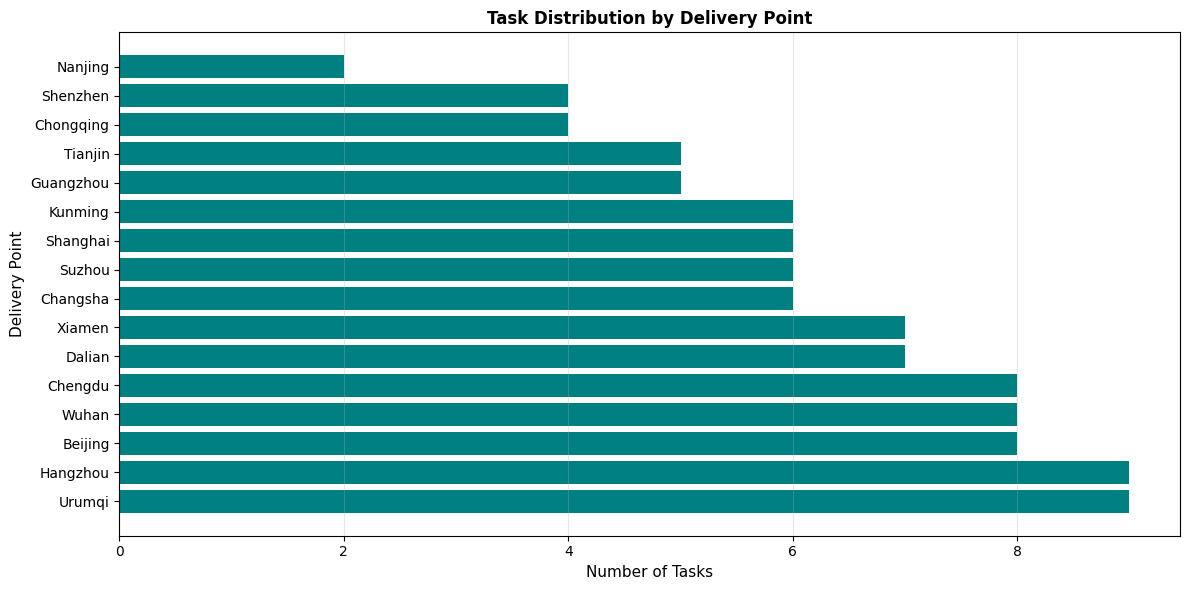

Most popular delivery point: Urumqi (9 tasks)
Least popular delivery point: Nanjing (2 tasks)


In [ ]:
# Analyze task-to-delivery point distribution
delivery_counts = task_df['end_point'].value_counts().sort_values(ascending=False)

fig, ax = plt.subplots(figsize=(12, 6))
ax.barh(delivery_counts.index, delivery_counts.values, color='teal')
ax.set_xlabel('Number of Tasks', fontsize=11)
ax.set_ylabel('Delivery Point', fontsize=11)
ax.set_title('Task Distribution by Delivery Point', fontsize=12, weight='bold')
ax.grid(axis='x', alpha=0.3)
plt.tight_layout()
plt.show()

print(f"Most popular delivery point: {delivery_counts.index[0]} ({delivery_counts.iloc[0]} tasks)")
print(f"Least popular delivery point: {delivery_counts.index[-1]} ({delivery_counts.iloc[-1]} tasks)")


In [ ]:
# Analyze urgent tasks
urgent_tasks = task_df[task_df['priority'] == 'Urgent']
print("=== Urgent Task Analysis ===")
print(f"Total urgent tasks: {len(urgent_tasks)}")
print(f"\nUrgent tasks by start point:")
print(urgent_tasks['start_point'].value_counts())
print(f"\nUrgent tasks by end point:")
print(urgent_tasks['end_point'].value_counts().head(10))


=== Urgent Task Analysis ===
Total urgent tasks: 2

Urgent tasks by start point:
start_point
Rabbit    1
Monkey    1
Name: count, dtype: int64

Urgent tasks by end point:
end_point
Hangzhou    1
Beijing     1
Name: count, dtype: int64


### 4.3 Simulation Results Analysis

If trajectory data exists, we can analyze the simulation results:


=== Simulation Results ===
Total simulation time: 243 time steps
Total trajectory records: 2928
Average records per time step: 12.00

=== AGV Activity Summary ===
             First_Move  Last_Move  Total_Moves  Time_Loaded  Time_Unloaded  \
name                                                                          
Bluestreak            0        243          244          128            116   
Bumblebee             0        243          244          136            108   
Hound                 0        243          244          143            101   
Ironhide              0        243          244          122            122   
Jazz                  0        243          244          121            123   
Megatron              0        243          244          147             97   
Optimus               0        243          244          128            116   
Ratchet               0        243          244          122            122   
RedAlert              0        243          244

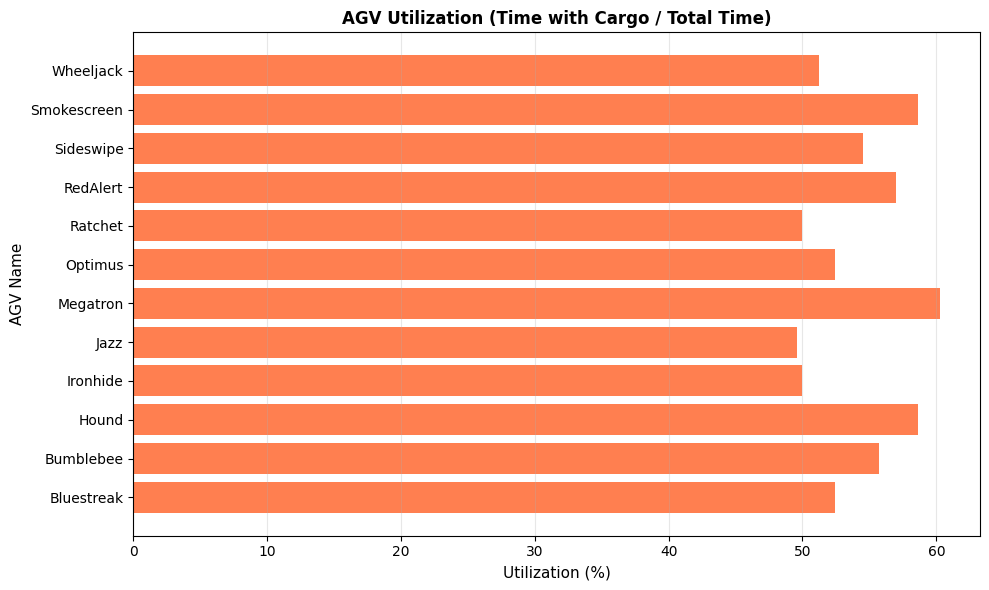

In [ ]:
try:
    # Load trajectory data
    trajectory_df = pd.read_csv('agv_trajectory.csv')
    
    # Convert loaded column to boolean
    # First convert to string if it's already boolean, then convert to boolean
    trajectory_df['loaded'] = trajectory_df['loaded'].astype(str).str.lower() == 'true'
    trajectory_df['Emergency'] = trajectory_df['Emergency'].astype(str).str.lower() == 'true'
    
    # Analyze simulation duration
    max_timestamp = trajectory_df['timestamp'].max()
    print(f"=== Simulation Results ===")
    print(f"Total simulation time: {max_timestamp} time steps")
    print(f"Total trajectory records: {len(trajectory_df)}")
    print(f"Average records per time step: {len(trajectory_df) / (max_timestamp + 1):.2f}")
    
    # Analyze AGV activity
    agv_activity = trajectory_df.groupby('name').agg({
        'timestamp': ['min', 'max', 'count'],
        'loaded': 'sum'
    }).round(2)
    agv_activity.columns = ['First_Move', 'Last_Move', 'Total_Moves', 'Time_Loaded']
    agv_activity['Time_Unloaded'] = agv_activity['Total_Moves'] - agv_activity['Time_Loaded']
    agv_activity['Utilization'] = (agv_activity['Time_Loaded'] / agv_activity['Total_Moves'] * 100).round(2)
    
    print("\n=== AGV Activity Summary ===")
    print(agv_activity)
    
    # Visualize AGV utilization
    fig, ax = plt.subplots(figsize=(10, 6))
    
    # Utilization bar chart
    ax.barh(agv_activity.index, agv_activity['Utilization'], color='coral')
    ax.set_xlabel('Utilization (%)', fontsize=11)
    ax.set_ylabel('AGV Name', fontsize=11)
    ax.set_title('AGV Utilization (Time with Cargo / Total Time)', fontsize=12, weight='bold')
    ax.grid(axis='x', alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
except FileNotFoundError:
    print("Trajectory file not found. Please run the simulation first.")
    print("To generate trajectory data, execute: python 'main right copy.py'")


=== Task Duration Analysis ===
Total tasks analyzed: 100
Average task duration: 14.87 time steps
Shortest task duration: 6 time steps
Longest task duration: 25 time steps
Median task duration: 16.00 time steps


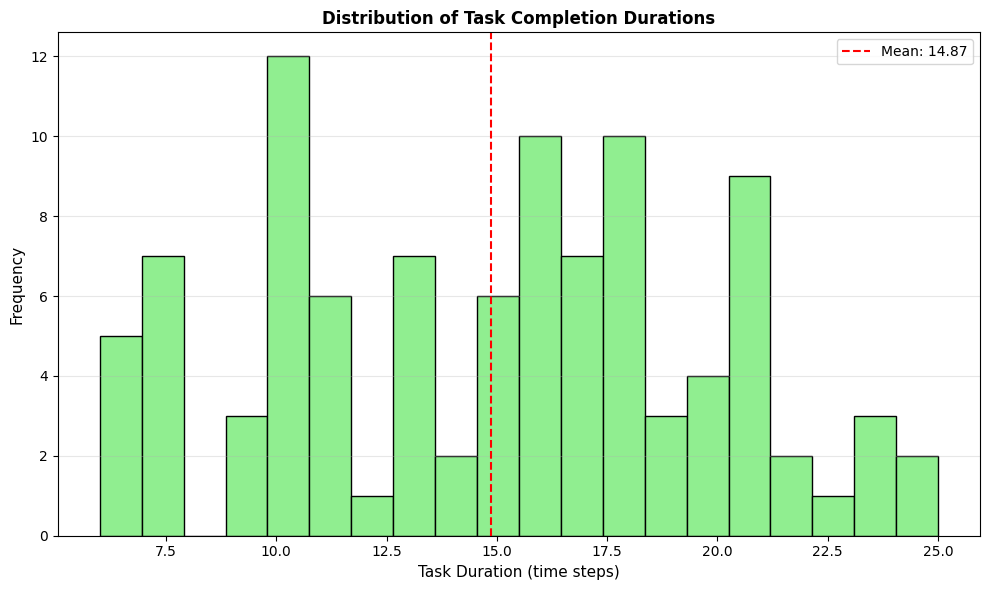

In [ ]:
try:
    # Analyze task completion timeline
    task_completions = trajectory_df[trajectory_df['task-id'] != ''].copy()
    
    # Find when each task was picked up (first time loaded=True for each task)
    task_pickups = task_completions[task_completions['loaded'] == True].groupby('task-id')['timestamp'].min()
    
    # Find when each task was delivered (last time loaded=True before becoming False)
    # For each task, find the last timestamp where loaded=True
    task_deliveries = task_completions[task_completions['loaded'] == True].groupby('task-id')['timestamp'].max()
    
    # Only calculate durations for tasks that have both pickup and delivery
    common_tasks = task_pickups.index.intersection(task_deliveries.index)
    task_durations = (task_deliveries[common_tasks] - task_pickups[common_tasks])
    
    # Filter out invalid durations (negative or zero)
    task_durations = task_durations[task_durations > 0]
    
    if len(task_durations) > 0:
        print("=== Task Duration Analysis ===")
        print(f"Total tasks analyzed: {len(task_durations)}")
        print(f"Average task duration: {task_durations.mean():.2f} time steps")
        print(f"Shortest task duration: {task_durations.min()} time steps")
        print(f"Longest task duration: {task_durations.max()} time steps")
        print(f"Median task duration: {task_durations.median():.2f} time steps")
        
        # Visualize task duration distribution
        fig, ax = plt.subplots(figsize=(10, 6))
        ax.hist(task_durations, bins=20, color='lightgreen', edgecolor='black')
        ax.axvline(task_durations.mean(), color='red', linestyle='--', 
                   label=f'Mean: {task_durations.mean():.2f}')
        ax.set_xlabel('Task Duration (time steps)', fontsize=11)
        ax.set_ylabel('Frequency', fontsize=11)
        ax.set_title('Distribution of Task Completion Durations', fontsize=12, weight='bold')
        ax.legend()
        ax.grid(axis='y', alpha=0.3)
        plt.tight_layout()
        plt.show()
    else:
        print("=== Task Duration Analysis ===")
        print("No valid task durations found. Check data format.")
    
except (FileNotFoundError, KeyError) as e:
    print(f"Cannot analyze task durations: {e}")


### 4.4 Visualization of AGV Trajectories

We can visualize the paths taken by AGVs:

check the generated mp4!!

---

## 5. Conclusion {#conclusion}

### 5.1 Key Findings

1. **Algorithm Effectiveness**: Our A* pathfinding algorithm successfully finds collision-free paths for all 12 AGVs, handling complex multi-agent scenarios with dynamic obstacles.

2. **Task Scheduling**: The cost-matrix-based task allocation effectively balances workload across AGVs while respecting priority constraints.

3. **Conflict Resolution**: The system successfully prevents collisions and path swaps through forward-looking obstacle prediction and swap detection.

4. **Scalability**: The system handles 102 tasks across 6 pickup points and 16 delivery destinations, demonstrating robustness for medium-scale warehouse operations.

### 5.2 Limitations

1. **Computational Complexity**: As the number of AGVs and tasks increases, the pathfinding and conflict resolution become computationally expensive. The current implementation may not scale well to very large fleets (50+ AGVs).

2. **Greedy Task Allocation**: The current task allocation uses a greedy approach, which may not always produce globally optimal solutions. More sophisticated optimization techniques (e.g., Hungarian algorithm, genetic algorithms) could improve overall efficiency.

3. **Static Environment**: The system assumes a static warehouse layout. Real-world scenarios may involve dynamic obstacles (e.g., human workers, temporary blockages) that are not currently handled.

4. **No Replanning**: Once a path is assigned, the system does not dynamically replan if better opportunities arise. This could lead to suboptimal long-term performance.

5. **Limited Priority Handling**: While urgent tasks receive priority weighting, the system does not implement strict deadline constraints or task cancellation mechanisms.

### 5.3 Reflection on Learning

This project provided valuable hands-on experience in:

- **Algorithm Implementation**: Implementing and adapting A* algorithm for multi-agent scenarios with temporal constraints
- **Data Engineering**: Processing and managing spatial-temporal data for simulation systems
- **Problem Decomposition**: Breaking down a complex multi-agent coordination problem into manageable components (pathfinding, task allocation, conflict resolution)
- **Visualization**: Creating effective visualizations to understand and communicate system behavior
- **Programming Best Practices**: Writing modular, maintainable code with proper data structures and algorithms

### 5.4 Future Improvements

1. **Advanced Pathfinding**: Implement more sophisticated MAPF algorithms (e.g., Conflict-Based Search, Push and Swap) for better scalability

2. **Optimization-Based Task Allocation**: Replace greedy allocation with optimization algorithms (e.g., linear programming, constraint programming) for global optimality

3. **Dynamic Replanning**: Add capability to replan paths when new information becomes available or when conflicts are detected

4. **Real-time Adaptation**: Implement mechanisms to handle dynamic obstacles and changing warehouse conditions

5. **Performance Metrics**: Add comprehensive metrics (throughput, makespan, AGV utilization) and compare against baseline algorithms

6. **Machine Learning Integration**: Explore using reinforcement learning for adaptive task allocation and path planning

7. **3D Visualization**: Enhance visualization to show AGV orientations, cargo states, and temporal evolution more clearly

---

## 6. References {#references}

1. Hart, P. E., Nilsson, N. J., & Raphael, B. (1968). A formal basis for the heuristic determination of minimum cost paths. *IEEE transactions on Systems Science and Cybernetics*, 4(2), 100-107.

2. Stern, R., et al. (2019). Multi-Agent Pathfinding: Definitions, Variants, and Benchmarks. *Proceedings of the International Symposium on Combinatorial Search*, 10(1), 151-158.

3. Python Software Foundation. (2023). Python 3 Documentation. https://docs.python.org/3/

4. Pandas Development Team. (2023). pandas: powerful Python data analysis toolkit. https://pandas.pydata.org/

5. Matplotlib Development Team. (2023). Matplotlib: Visualization with Python. https://matplotlib.org/

---

*End of Report*
